In [1]:
using Pkg
Pkg.activate(".")
ENV["PYTHON"] = "/opt/homebrew/Caskroom/miniforge/base/bin/python"
using JSON, Clustering, StatsBase, StatsPlots, RollingFunctions, MultivariateStats, HDBSCAN
theme(:dracula)

function stdize(X)
    X_mean = mean(X)
    X_std = std(X)
    X .= (X .- X_mean) ./ X_std
    return X
end

function normalize(X, a, b)
    X .= (X .- minimum(X)) .* (b - a) ./ (maximum(X) .- minimum(X)) .+ a
    return X
end


  Activating project at `~/BayesCSF/Segmentation`


normalize (generic function with 1 method)

In [2]:
json_string = read("SegmentationData.json", String)
read_data = JSON.parse(json_string);  # Convert the JSON-formatted string to a Dict

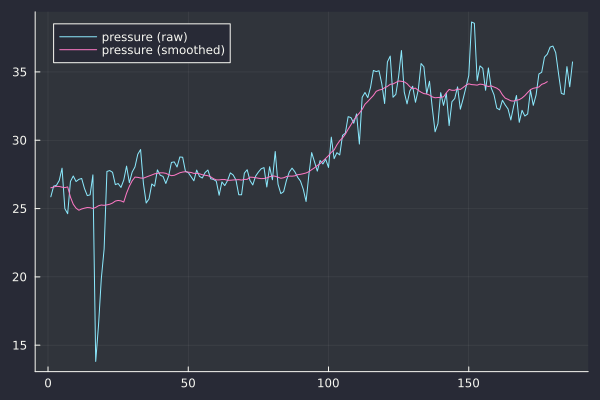

In [3]:
theme(:dracula)

fid = 22
file_data = read_data[fid]

transition_start = read_data[fid]["transition_start"]
transition_end = read_data[fid]["transition_end"]
baseline_start = read_data[fid]["baseline_start"]
baseline_end = read_data[fid]["baseline_end"]
plateau_start = read_data[fid]["plateau_start"]
plateau_end = read_data[fid]["plateau_end"]
icp = read_data[fid]["pressure"]

inf_end = read_data[fid]["infusion_end"]
icp = icp[1:inf_end]
plot(icp, label="pressure (raw)")

smooth_factor = 20
# icp_smooth = moving_average(icp, smooth_factor)
icp_smooth = runmean(Float64.(icp), smooth_factor)
icp_var = runvar(Float64.(icp_smooth), smooth_factor)
icp_std = runstd(Float64.(icp_smooth), smooth_factor)
icp_kurt = runkurtosis(Float64.(icp_smooth), smooth_factor)
d_icp_smooth = diff(icp_smooth)
dd_icp_smooth = diff(d_icp_smooth)

plot!(icp_smooth[Int64(round(smooth_factor/2)):end], label="pressure (smoothed)")

labels = zeros(length(icp_smooth))
labels[baseline_start:baseline_end] .= 1
labels[transition_start:transition_end] .= 3
labels[plateau_start:minimum([plateau_end, length(icp)])] .= 2

plot!()


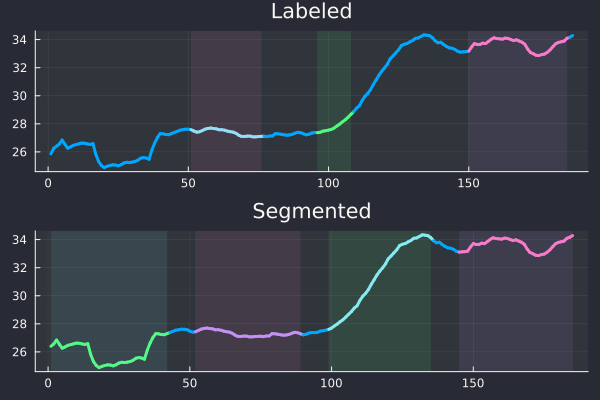

In [4]:
# fuzzy c-means

indexes = Float64.(collect(1:length(d_icp_smooth)))

X = hcat(d_icp_smooth[2:end], icp_smooth[3:end], dd_icp_smooth, indexes[2:end], icp_kurt[3:end], icp_std[3:end], icp_var[3:end])

X = hcat(
        stdize(d_icp_smooth[2:end]),
        stdize(icp_smooth[3:end]),
        stdize(dd_icp_smooth),
        stdize(icp_std[3:end]),
        stdize(icp_kurt[3:end]),
        stdize(icp_var[3:end]),
        normalize(indexes[2:end], 0, 100)
)

res = fuzzy_cmeans(X', 4, 1.5)

wghts = res.weights

resw = wghts .> 0.8

res_ass = zeros(length(wghts[:, 1]))
vec = resw[:, 1] .== 1
res_ass[vec] .= 1
vec = resw[:, 2] .== 1
res_ass[vec] .= 2
vec = resw[:, 3] .== 1
res_ass[vec] .= 3
vec = resw[:, 4] .== 1
res_ass[vec] .= 4

res_ass = Int64.(res_ass)

ptrue = plot(icp_smooth, color=Int64.(labels), legend=false, title="Labeled", lw=3)
vspan!([baseline_start, baseline_end], alpha=0.1)
annotate!((baseline_start+baseline_end)/2, maximum(icp_smooth)/2, "baseline")

vspan!([transition_start, transition_end], alpha=0.1)
annotate!((transition_start+transition_end)/2, maximum(icp_smooth)/2, "transition")

vspan!([plateau_start, plateau_end], alpha=0.1)
annotate!((plateau_start+plateau_end)/2, maximum(icp_smooth)/2, "plateau")

pseg = plot(icp_smooth[3:end], color=res_ass, legend=false, title="Segmented", lw=3)

firsts = [findfirst(res_ass .== 1)
        findfirst(res_ass .== 2)
        findfirst(res_ass .== 3)
        findfirst(res_ass .== 4)]

sorted = sort(firsts)

anntxt = ["baseline 1", "baseline2", "transition", "plateau"]

counter = 0
for i in sorted
        counter+=1
        first = findfirst(i .== firsts)
        vspan!([findfirst(res_ass .== first), findlast(res_ass .== first)], alpha=0.1, color=counter)
        annotate!((findfirst(res_ass .== first) + findlast(res_ass .== first)) / 2, 0.5*maximum(icp_smooth), anntxt[counter])
end

plot(ptrue, pseg, layout=(2, 1))



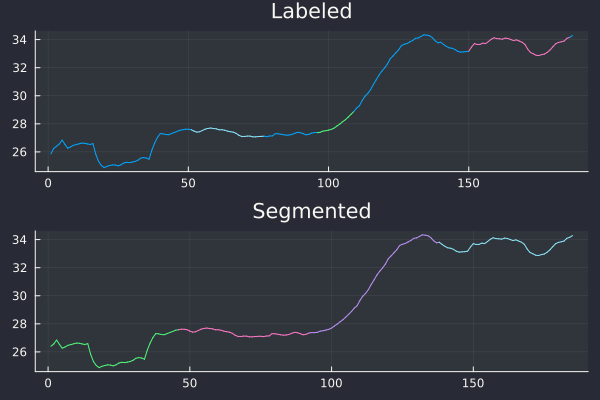

In [5]:
# kmeans

X = hcat(d_icp_smooth[2:end], icp_smooth[3:end], dd_icp_smooth, indexes[2:end], icp_kurt[3:end], icp_std[3:end], icp_var[3:end])

X = hcat(
        stdize(d_icp_smooth[2:end]),
        stdize(icp_smooth[3:end]),
        stdize(dd_icp_smooth),
        stdize(icp_std[3:end]),
        stdize(icp_kurt[3:end]),
        stdize(icp_var[3:end]),
        normalize(indexes[2:end], 0, 100)
)

res = kmeans(X', 4)
res_ass = res.assignments

# sc = scatter(d_icp_smooth[2:end], icp_smooth[3:end], color=res_ass,
#         xlabel="dICP", ylabel="ICP",
#         title="Clustering Results", legend=false)

lp = plot(icp_smooth[3:end], color=res_ass, xlabel="Time", ylabel="ICP", legend=false)

ptrue = plot(icp_smooth, color=Int64.(labels),legend=false, title="Labeled")
pseg = plot(icp_smooth[3:end], color=res_ass,legend=false, title="Segmented")
plot(ptrue, pseg, layout=(2,1))

# plot(lp, sc, layout=(2, 1))